Name: Arda Meriç
Student Id: 2310332

In [225]:
import cv2
from matplotlib import pyplot as plt
import numpy as np
import timeit
# Save image in set directory
# Read RGB image
img1 = cv2.imread('chessboard.png')
img2 = cv2.imread('chessboardrotated.png')
img3 = cv2.imread('agac.png')
img4 = cv2.imread('agacrotated.png')
img5 = cv2.imread('lab.png')
img6 = cv2.imread('labrotated.png')
images = [img1,img2,img3,img4,img5,img6]
size_window = 5

libpng warning: iCCP: known incorrect sRGB profile


In [240]:
# USEFUL FUNCTIONS

# get indexes of the highest responses than add indexes for the corresponding maximum_pixel
def index_k_values(weights, k, window_size):
    loop_val = window_size // 2
    idx = np.argpartition(weights.ravel(), -k)
    ind = tuple(np.array(np.unravel_index(idx, weights.shape))[:, range(min(-k, 0), max(-k, 0))])
    x_arr = []
    y_arr = []
    for x,y in zip(ind[0],ind[1]):
        for k in range(window_size):
            for l in range(window_size):
                x_arr.append(x+(k-loop_val))
                y_arr.append(y+(l-loop_val))
    return np.array(x_arr),np.array(y_arr)

# takes the function_name and its parameters -> returns function output and time taken
def time_calc(func, parameters):
    if type(parameters) is not tuple:
        raise Exception('Give parameters as tuple.')

    start = timeit.default_timer()
    inner_return = func(*parameters)
    stop = timeit.default_timer()
    time_return = 'Time: {:.2f}'.format(stop - start)
    return inner_return, time_return

# runs the function for each image and plots the results
def easy_run(images,function,task_num):
    fig = plt.figure(figsize=(12, 8))
    rows = 2
    columns = 3
    for i in range(6):
        img = images[i]
        gray_image = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        gray_image = np.float32(gray_image)
        img_task = img.copy()
        weights, time_val = time_calc(function,(gray_image,size_window))
        if task_num != 1:
            weights = non_max_supression(weights, 9)
        ind = index_k_values(weights,10,size_window)
        img_task[ind] = (255,0,0)

        fig.add_subplot(rows, columns, i+1)

        # showing image
        plt.imshow(img_task)
        plt.axis('off')
        plt.title(f'Task {task_num} Corners - ' + time_val)
        
        
    plt.show()
    

### Task 1: Naive Formula + Uniform Weighting

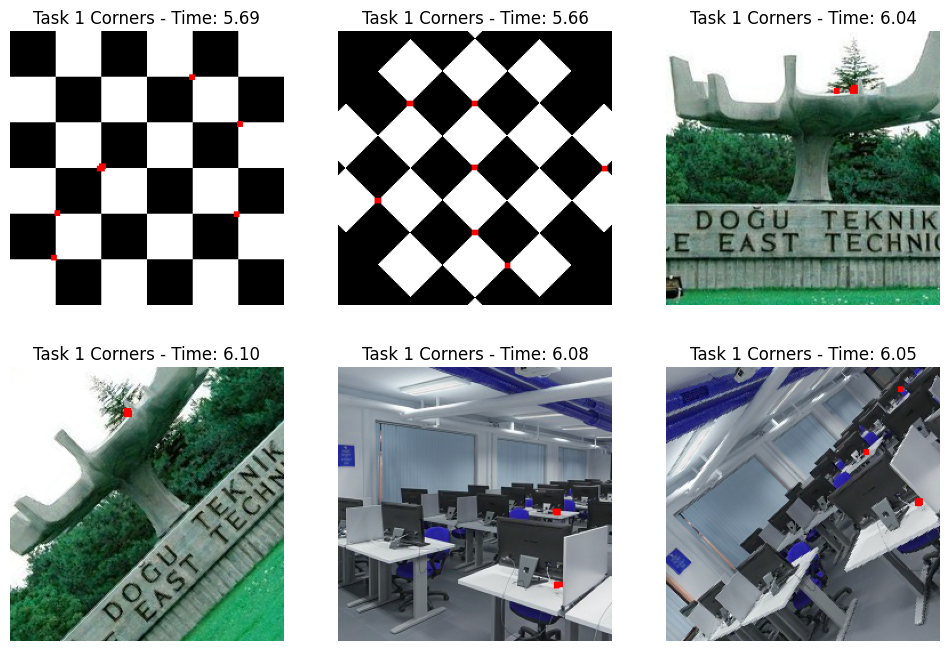

In [227]:
## Write your code here

def naive_uniform(image, window_size):

	height = image.shape[0]
	width = image.shape[1]
	loop_value = window_size // 2

	weights = np.zeros((height, width))
	for i in range(loop_value+1,height-loop_value-1):
		for j in range(loop_value+1,width-loop_value-1):
			# visit around that pixel
			square_sum = 0
			for x in range(window_size):
				for y in range(window_size):
					uv_difference = 0
					pixel_value = image[i+(x-loop_value)][j+(y-loop_value)]
					for u in range(3):
						for v in range(3):
							visit_sum_rgb = image[i+(x-loop_value)+(u-1)][j+(y-loop_value)+(v-1)]
							uv_difference += pow((int(visit_sum_rgb) - int(pixel_value)), 2)
					square_sum += uv_difference / 8

			weights[i][j] = square_sum
	return weights

easy_run(images,naive_uniform,1)


E(u,v) = ∑ w(x,y) [ I(x+u,y+v) – I(x,y)]^2

The code calculates uniform weighting in the window. Window is 8 pixel(Window can be any size) surrounding pixels of I(x,y). Since there is no non-max supression, the corner values(higher responds) grouping. As the window size gets bigger, there will be more crowded groups of corners. 


### Task2: Naive Formula + Uniform Weighting + Non-Maximum Suppression

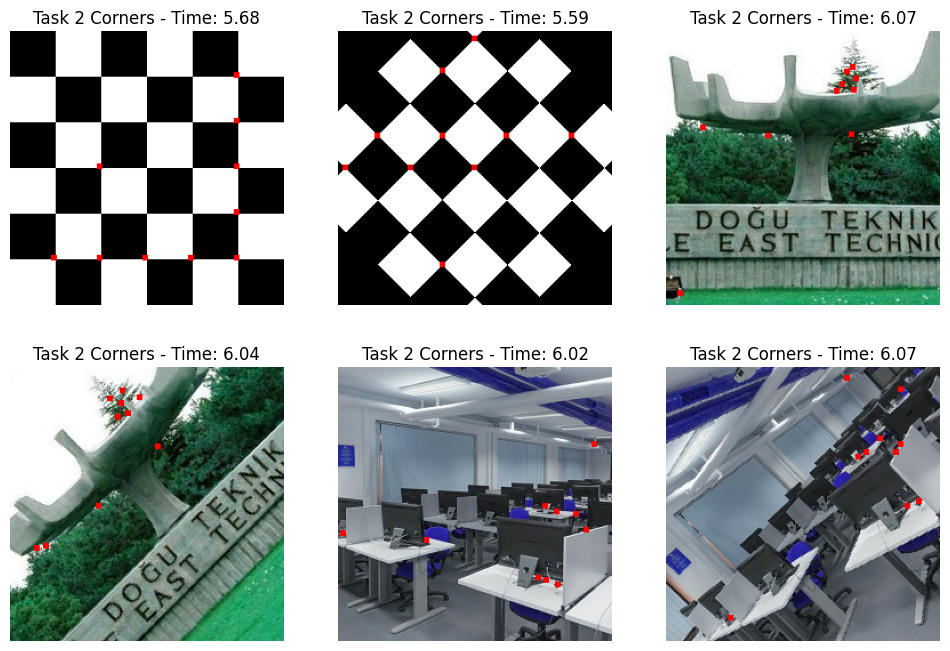

In [228]:
## Write your code here

def non_max_supression(weights, window_size):
    loop_value = window_size // 2
    for x in range(loop_value, weights.shape[0]-loop_value,window_size):
        for y in range(loop_value, weights.shape[1]-loop_value,window_size):
            """max_val = np.max(weights[x-loop_value:x+loop_value+1,y-loop_value:y+loop_value+1])
            weights[x-loop_value:x+loop_value+1,y-loop_value:y+loop_value+1] = np.full(weights[x-loop_value:x+loop_value+1,y-loop_value:y+loop_value+1].shape,0)
            weights[x][y] = max_val"""
            sx = slice(x-loop_value,x+loop_value+1)
            sy = slice(y-loop_value,y+loop_value+1)
            slicing_part = weights[sx,sy]
            max_val = np.max(slicing_part)
            x_max,y_max = np.unravel_index(slicing_part.argmax(), slicing_part.shape)
            slicing_part[x_max][y_max] += 1
            x_max += x-loop_value
            y_max += y-loop_value
            slicing_part[slicing_part != max_val+1] = 0
            new_slicex = slice(max(0,x_max - loop_value), min(weights.shape[0], x_max + loop_value + 1))
            new_slicey = slice(max(0,y_max - loop_value), min(weights.shape[1], y_max + loop_value + 1))
            #print(x_max, y_max)
            slicing_part_max = weights[new_slicex, new_slicey]
            x_max2,y_max2 = np.unravel_index(slicing_part_max.argmax(), slicing_part_max.shape)
            slicing_part_max[x_max2][y_max2] += 1
            slicing_part_max[slicing_part_max != np.max(slicing_part_max)] = 0
    return weights

easy_run(images,naive_uniform,2)


Non-max supression is used to get rid of the corner pixels that are close to each other. Before non-max supression there were 10-11 corners for 'chessboard.png' when I try to display 20 corners. They were overlapping and close to each other. The function takes pixel weights and window size. Within the window, it sets 0 for the non-max value weights. Since a max value can be in window[0,0] and the other one can be in window[len(window)-1,len(window)-1], the function sets another window that its center is the maximum value, then it again finds the maximum value within this window and sets others to 0. When I call the function with window size bigger than 5, then I can see 20 corners as I desire.

### Task3: Taylor's Approximation + Uniform Weighting + Non-Maximum Suppression

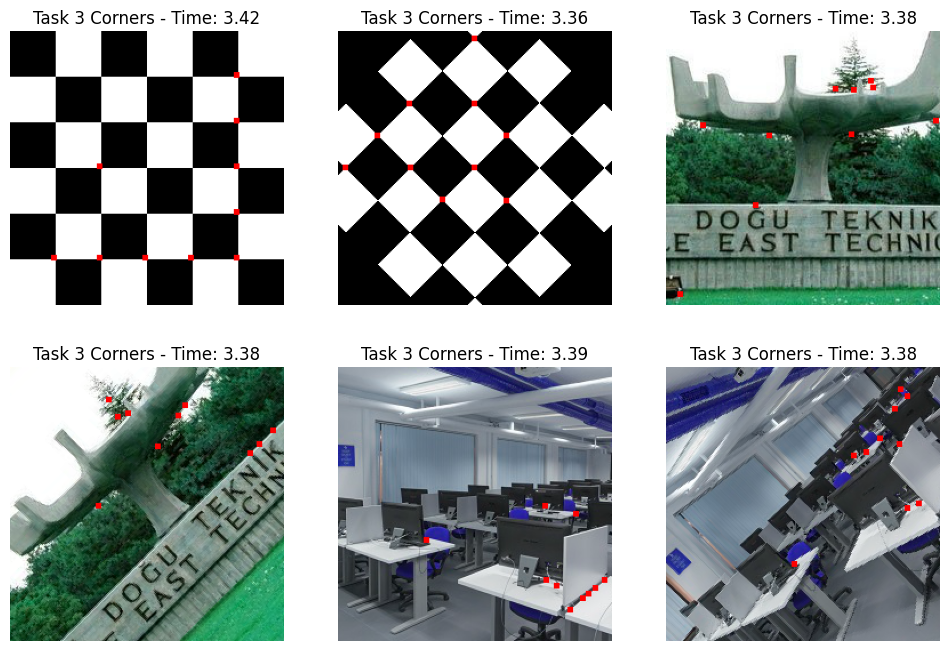

In [229]:
## Write your code here
def taylors_approx(img, window_size=3):
    height = img.shape[0]
    width = img.shape[1]
    weights = np.zeros((height, width))
    Ix, Iy = np.gradient(img)
    Ix2=np.square(Ix)
    Iy2=np.square(Iy)
    Ixy=Ix*Iy
    loop_val = window_size // 2
    for i in range(loop_val+1, height-loop_val-1):
        for j in range(loop_val+1, width-loop_val-1):
            H = np.zeros((2,2))
            for x in range(window_size):
                for y in range(window_size):
                    ix = i+(x-loop_val)
                    jy = j+(y-loop_val)
                    H += np.array([[Ix2[ix][jy],Ixy[ix][jy]],[Ixy[ix][jy],Iy2[ix][jy]]])
            res = 0
            for u in range(3):
                for v in range(3):
                    res += int(np.matmul(np.matmul(np.array([[u-1,v-1]]),H),np.array([[u-1],[v-1]])))
            weights[i][j] = res
    return weights


easy_run(images,taylors_approx,3)



E(u,v) = ∑ (u,v)M(u,v)T

Help of the Taylor's Series Expansion, rather than calculating the squared difference for each pixel in each window, the same H matrix can be multiplied with direction vectors. Average time of 6 seconds is dropped significantly to 3-4 seconds. The corners are a little bit away from their original pixels since there is no convolution involved in this task. However, the accuracy of the corners is worse that task2.


### Task 4: Smaller Eigenvalue as corner score + Uniform Weighting + Non-Maximum Suppression

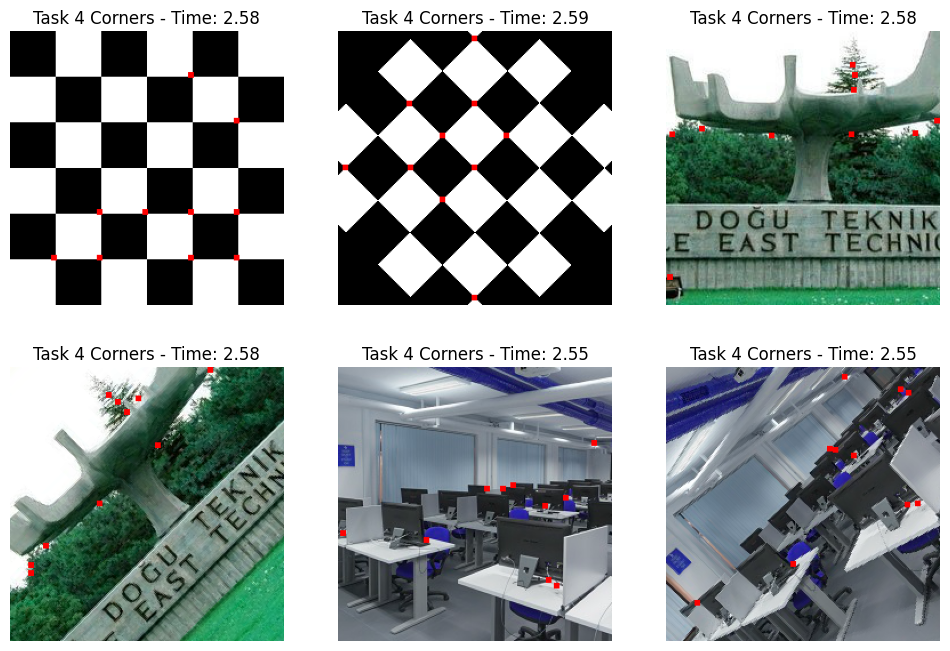

In [230]:
## Write your code here
def smaller_eigen_value(img, window_size=3):
    height = img.shape[0]
    width = img.shape[1]
    weights = np.zeros((height, width))
    Ix, Iy = np.gradient(img)
    Ix2=np.square(Ix)
    Iy2=np.square(Iy)
    Ixy=Ix*Iy
    loop_val = window_size // 2
    for i in range(loop_val, height-loop_val):
        for j in range(loop_val, width-loop_val):
            H = np.zeros((2,2))
            for x in range(window_size):
                for y in range(window_size):
                    ix = i+(x-loop_val)
                    jy = j+(y-loop_val)
                    H += np.array([[Ix2[ix][jy],Ixy[ix][jy]],[Ixy[ix][jy],Iy2[ix][jy]]])
            min_eigen = np.min(np.linalg.eig(H)[0])
            weights[i][j] = min_eigen
    return weights

easy_run(images,smaller_eigen_value,4)


Using smaller eigenvalue increase the program speed since it calculates eigenvalues rather than iterating to all 8 directions. 

The corners are a little bit away from their original pixels since there is no convolution involved in this task.


### Task 5: R function as corner score + Uniform Weighting + Non-Maximum Suppression

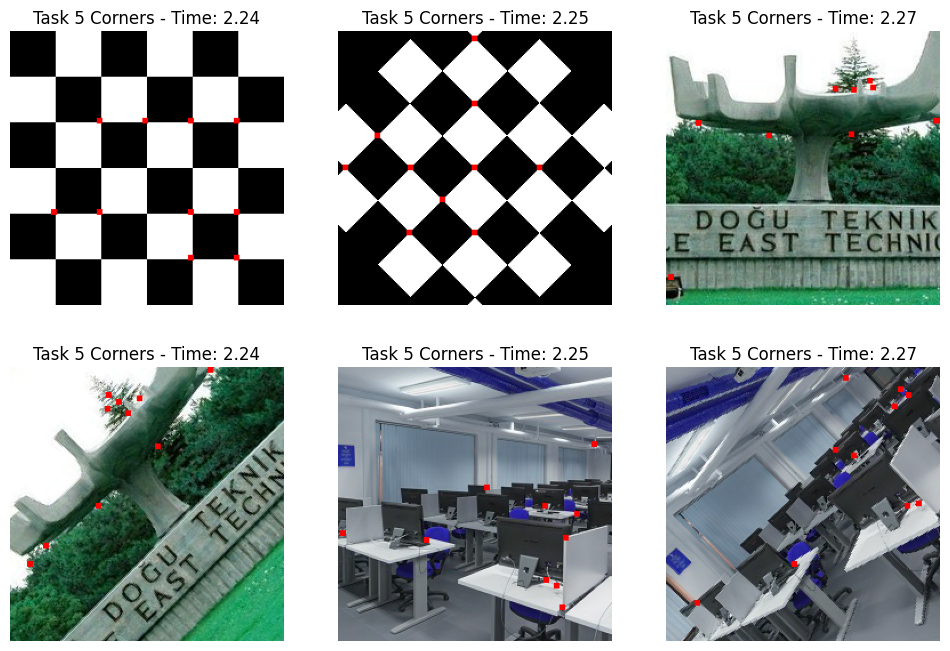

In [231]:
## Write your code here
def r_value_weight(img, window_size=3):
    k = 0.04
    height = img.shape[0]
    width = img.shape[1]
    weights = np.zeros((height, width))
    Ix, Iy = np.gradient(img)
    Ix2=np.square(Ix)
    Iy2=np.square(Iy)
    Ixy=Ix*Iy
    loop_val = window_size // 2
    for i in range(loop_val, height-loop_val):
        for j in range(loop_val, width-loop_val):
            H = np.zeros((2,2))
            for x in range(window_size):
                for y in range(window_size):
                    ix = i+(x-loop_val)
                    jy = j+(y-loop_val)
                    H += np.array([[Ix2[ix][jy],Ixy[ix][jy]],[Ixy[ix][jy],Iy2[ix][jy]]])
            det=np.linalg.det(H)
            trace=np.matrix.trace(H)
            res = det-k*(trace ** 2)
            weights[i][j] = res
    return weights
    
easy_run(images,r_value_weight,5)

Calculating R- function rather than calculating smaller eigenvalue is a bit faster since there is no square-root calculation involved. I think the accuracy of the corners increased in this case. The r-value tells that both eigenvalues are large and hence it is a better solution than samller eigenvalue technique.



### Task 6: R function with fast windowing based on fitering + Uniform Weighting + Non-Maximum Suppression

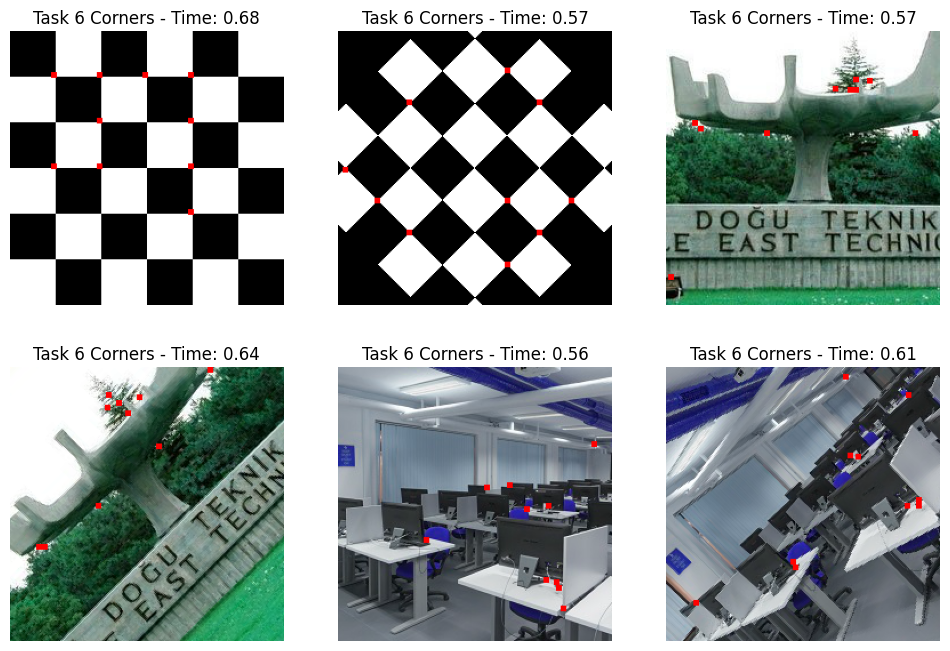

In [233]:
## Write your code here
def r_fast_filtering(img, window_size=3):
    k = 0.04
    height = img.shape[0]
    width = img.shape[1]
    weights = np.zeros((height, width))
    Ix, Iy = np.gradient(img)
    Ix2=np.square(Ix)
    Iy2=np.square(Iy)
    Ixy=Ix*Iy
    loop_val = window_size // 2
    for i in range(loop_val, height-loop_val):
        for j in range(loop_val, width-loop_val):
            si = slice(i-loop_val,i+1+loop_val)
            sj = slice(j-loop_val,j+1+loop_val)
            Sx2 = np.sum(Ix2[si, sj])
            Sy2 = np.sum(Iy2[si, sj])
            Sxy = np.sum(Ixy[si, sj])
            M = np.array([[Sx2,Sxy],[Sxy,Sy2]])
            det=np.linalg.det(M)
            trace=np.matrix.trace(M)
            r_val = det-k*(trace ** 2)
            weights[i, j] = r_val
    cv2.normalize(weights, weights, 0, 1, cv2.NORM_MINMAX)
    return weights
    
easy_run(images,r_fast_filtering,6)

Fast windowing technique is the fastest among all techniques since it does not iterate through the whole window, yet it sums over a square window. I could not notice an accuracy improvement when I compare it with the normal R function technique.


### Task 7: R function with fast windowing based on fitering + Gaussian Weighting + Non-Maximum Suppression

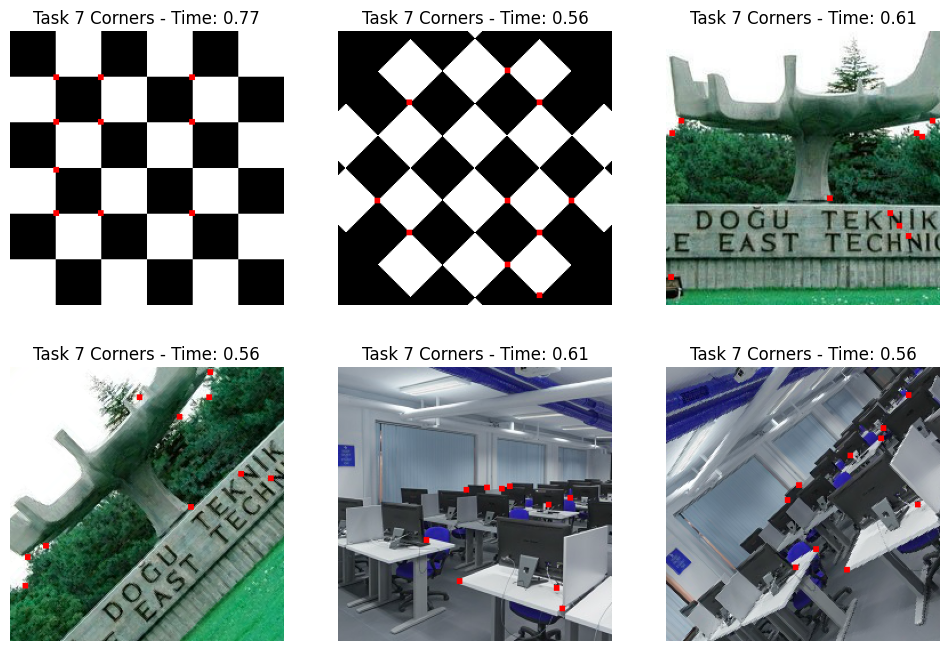

In [241]:
## Write your code here
def r_fast_filtering_gaussian(img, window_size=3):
    img = cv2.GaussianBlur(img,(window_size,window_size),0)
    k = 0.04
    height = img.shape[0]
    width = img.shape[1]
    weights = np.zeros((height, width))
    Ix, Iy = np.gradient(img)
    Ix2=np.square(Ix)
    Iy2=np.square(Iy)
    Ixy=Ix*Iy
    loop_val = window_size // 2
    for i in range(loop_val, height-loop_val):
        for j in range(loop_val, width-loop_val):
            si = slice(i-loop_val,i+1+loop_val)
            sj = slice(j-loop_val,j+1+loop_val)
            Sx2 = np.sum(Ix2[si, sj])
            Sy2 = np.sum(Iy2[si, sj])
            Sxy = np.sum(Ixy[si, sj])
            M = np.array([[Sx2,Sxy],[Sxy,Sy2]])
            det=np.linalg.det(M)
            trace=np.matrix.trace(M)
            r_val = det-k*(trace ** 2)
            weights[i, j] = r_val
    cv2.normalize(weights, weights, 0, 1, cv2.NORM_MINMAX)
    return weights
    
easy_run(images,r_fast_filtering_gaussian,7)

When gaussian blur added added to r-function fast filtering, the corner location accuracy is increased(more weighted to the center).


## At the end, 
all implementations were succesfull enough. However, after gaussian filter is added, the corner accuracy and corner location accuracy is increased. For example in 'agac.png', previous techniques were finding corners on the tree generally while the last task finds the corners more logically. After each step, the speed of the program increased since there is more mathmatics and less iteration involved.